# Group level statistics


## Retrieving First-Level results
As we now have the same contrast results from multiple `subjects`, we can define our `group level model`. First, we need to gather the `individual contrast maps`.

In [3]:
import os
from bids.layout import BIDSLayout

ds_path = '/imaging/correia/da05/workshops/2023-CBU/demo/FaceRecognition'
# Initialize the BIDS layout and include the derivatives in it
layout = BIDSLayout(os.path.join(ds_path, 'data/bids'), derivatives = True)
# Attach the results folder to the layout. It must complay with BIDS standards. 
# And must include dataset_description.json file!
layout.add_derivatives(os.path.join(ds_path, "results", "first-level"))

We will collect individual t-maps (`stat`) that represent the BOLD activity estimate divided by the uncertainty about this estimate. 

We will first look at only the **Faces > Scrambled** contrast. 

In [4]:
contrast = 'FacesScrambled'
stat_files = layout.get(desc = contrast, suffix='stat', extension = '.nii.gz')
print(*stat_files, sep = "\n")

<BIDSImageFile filename='/imaging/correia/da05/workshops/2023-CBU/demo/FaceRecognition/results/first-level/sub-01/sub-01_task-facerecognition_desc-FacesScrambled_stat.nii.gz'>
<BIDSImageFile filename='/imaging/correia/da05/workshops/2023-CBU/demo/FaceRecognition/results/first-level/sub-02/sub-02_task-facerecognition_desc-FacesScrambled_stat.nii.gz'>
<BIDSImageFile filename='/imaging/correia/da05/workshops/2023-CBU/demo/FaceRecognition/results/first-level/sub-03/sub-03_task-facerecognition_desc-FacesScrambled_stat.nii.gz'>
<BIDSImageFile filename='/imaging/correia/da05/workshops/2023-CBU/demo/FaceRecognition/results/first-level/sub-04/sub-04_task-facerecognition_desc-FacesScrambled_stat.nii.gz'>
<BIDSImageFile filename='/imaging/correia/da05/workshops/2023-CBU/demo/FaceRecognition/results/first-level/sub-05/sub-05_task-facerecognition_desc-FacesScrambled_stat.nii.gz'>
<BIDSImageFile filename='/imaging/correia/da05/workshops/2023-CBU/demo/FaceRecognition/results/first-level/sub-06/sub-06

We will want to display subject ID on top of their individual t-maps. Therefore we need to link each stat file with the corresponding subject ID. There are several ways to do this. The simplest seems to retrieve the subject list from the BIDS layout. But `PyBIDS` returns unsorted subject list, that's a bit problematic. And for some reason, sort() does not work on it. 

In [5]:
print(layout.get_subjects())

['16', '06', '03', '14', '04', '09', '10', '15', '01', '11', '07', '05', '08', '02', '12', '13']


Therefore I will sort it this way: 

In [6]:
subjects = sorted(list(set([f.get_entities().get("subject") for f in stat_files])))
print(subjects)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']


## Displaying subject t-maps

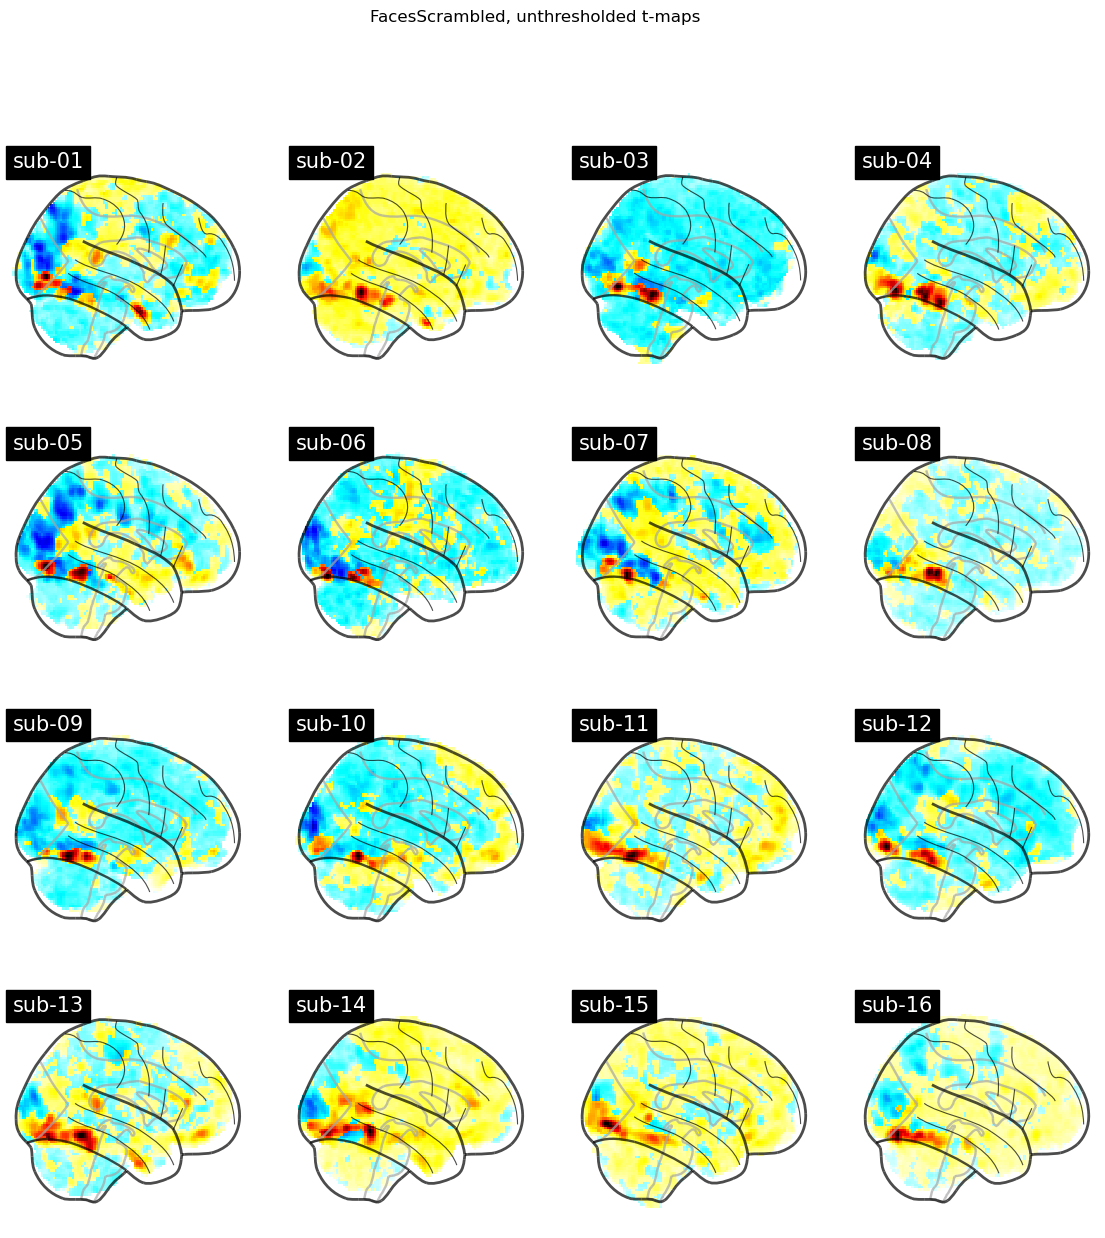

In [7]:
from nilearn import plotting
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 14))

for i, stat_map in enumerate(stat_files):
    plotting.plot_glass_brain(stat_map.path, 
                              title = 'sub-' + subjects[i],
                              axes = axes[int(i / 4), int(i % 4)],
                              plot_abs = False, 
                              display_mode='x')
fig.suptitle(contrast + ', unthresholded t-maps')
plotting.show()

## Estimate second level model

### Design matrix

The next step includes the definition of a `design matrix`. Here we will want to run a simple `one-sample t-test`. We just need to indicate as many `1` as we have subjects with first-level results.

In [8]:
import pandas as pd
design_matrix = pd.DataFrame(
    [1] * len(stat_files),
    columns=['intercept'])
design_matrix

intercept
0           1
1           1
2           1
3           1
4           1
5           1
6           1
7           1
8           1
9           1
10          1
11          1
12          1
13          1
14          1
15          1

### Model specification and fit

In [9]:
from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(smoothing_fwhm = 8.0)
second_level_model = second_level_model.fit(
    stat_files,
    design_matrix = design_matrix)

### Contrast estimation

In [10]:
z_map = second_level_model.compute_contrast(output_type='z_score')

### Thresholding and plotting

Uncorrected p<.001 threshold: 3.090


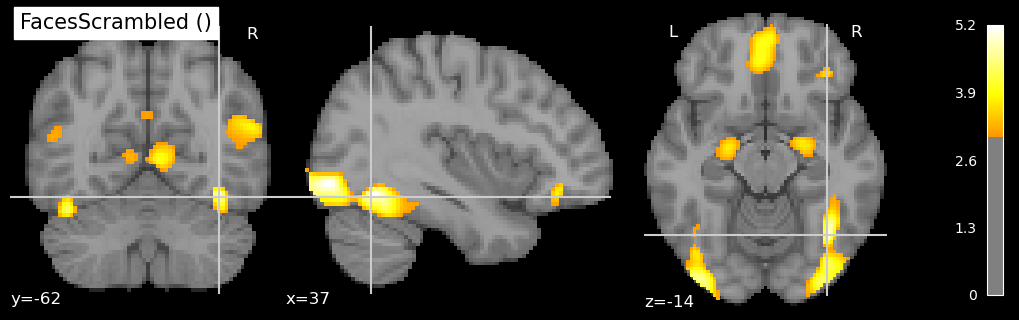

In [17]:
from nilearn.glm.thresholding import threshold_stats_img

cluster_map, threshold = threshold_stats_img(
    z_map, alpha=0.001, 
    height_control='fpr', 
    cluster_threshold=0,
    two_sided=False)

# displaying on mni152 template brain
from nilearn.datasets import load_mni152_template
template = load_mni152_template()

print('Uncorrected p<.001 threshold: %.3f' % threshold)
plotting.plot_stat_map(
    cluster_map, 
    threshold = threshold,       
    display_mode = 'ortho',
    cut_coords = [37,-62,-14],
    black_bg = True,
    bg_img = template,
    title = contrast + ' ()')

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

FWE p<.05 threshold: 5.064


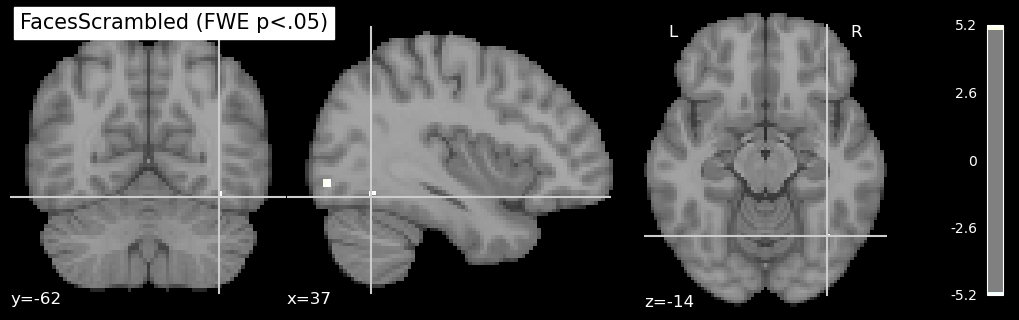

In [20]:
_, threshold = threshold_stats_img(
    z_map, alpha=0.05, 
    height_control='bonferroni', 
    cluster_threshold=0,
    two_sided=False)

from nilearn.datasets import load_mni152_template
template = load_mni152_template()

print('FWE p<.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(
    z_map, 
    threshold = threshold,       
    display_mode = 'ortho',
    cut_coords = [37,-62,-14],
    black_bg = True,
    bg_img = template,
    title = contrast + ' (FWE p<.05)')

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

We can also look at a 3D brain using `plotly`.

In [21]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()

_, threshold = threshold_stats_img(
    z_map, alpha = 0.001, 
    height_control = 'fpr',
    two_sided = True)

view = plotting.view_img_on_surf(z_map, threshold=threshold)
# view.open_in_browser()
view

Let's get some more summary results. Here we will get a cluster table. 

In [22]:
from nilearn.reporting import get_clusters_table
get_clusters_table(z_map, threshold, cluster_threshold=20, two_sided=False, min_distance=8.0)

Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1  37.5 -60.5 -12.5   5.212983               3368
1          1a  39.5 -54.5 -18.5   4.813691                   
2          1b  41.5 -40.5 -20.5   3.808459                   
3           2  37.5 -84.5  -8.5   5.212405               5704
4           3 -36.5 -88.5 -12.5   4.753403               5144
5          3a -42.5 -60.5 -22.5   4.569233                   
6          3b -42.5 -74.5 -14.5   3.743251                   
7           4   5.5 -50.5  23.5   4.383004               1096
8           5 -48.5 -68.5  19.5   4.311146               1184
9           6  -0.5  39.5 -20.5   4.232113               3832
10         6a   1.5  55.5 -12.5   4.013018                   
11          7   5.5 -60.5   5.5   4.219884               3024
12         7a  11.5 -74.5  15.5   3.833584                   
13          8 -38.5 -10.5 -30.5   4.203398               1184
14          9  55.5 -64.5  21.5   3.948100               1640
15         10 -10.5  59.5  25.5   3.885832               1184
16        10a -16.5  59.5  37.5   3.735132                   
17         11 -22.5 -10.5 -12.5   3.815886                736
18         12  23.5  -6.5 -16.5   3.814120                752
19         13  37.5  35.5 -12.5   3.811012                232
20         14  21.5 -48.5   5.5   3.702249                176
21         15  31.5  -4.5 -34.5   3.608829                168

Can create more complete reports with [nilearn.reporting](https://nilearn.github.io/dev/modules/generated/nilearn.reporting.make_glm_report.html).

In [ ]:

"""from nilearn.reporting import make_glm_report

report = make_glm_report(model = second_level_model,
                         contrasts = 'intercept',
                         threshold = threshold,
                         cluster_threshold = 20,
                         display_mode = 'ortho'
                         )

report
"""

Or we can use ['atlasreader'](https://github.com/miykael/atlasreader) package, as demonstrated in the below script to create reports for all our contrasts. 

## Second level for multiple contrasts

The script below will generate outputs of group-level results for multiple contrasts. 

In this example, we want to threshold the results to **Family-wise error corrected at p < .05**. 

In addition to getting our result maps, we will use *atlasreader* to generate result tables and peak cluster images. 

In [25]:
import warnings;
warnings.filterwarnings('ignore');

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# ======================================================================
# Dace Apšvalka (MRC CBU 2022)
# Group level fMRI analysis using Nilearn
# ======================================================================

# ======================================================================
# IMPORT RELEVANT PACKAGES
# ======================================================================
import os
import numpy as np
import pandas as pd
from bids.layout import BIDSLayout
from nilearn.datasets import load_mni152_template
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.reporting import get_clusters_table
from atlasreader import create_output


# ======================================================================
# WHICH CONTRASTS
# ======================================================================
contrasts = {'FamousUnfamiliar': 'Famous > Unfamiliar',
             'UnfamiliarFamous': 'Unfamiliar > Famous',
             'FacesScrambled': 'Faces > Scrambled',
             'ScrambledFaces': 'Scrambled > Faces'}
# ======================================================================
# WHAT THRESHOLD
# ======================================================================
height_control ='bonferroni' # bonferroni is FWE; fpr is uncorrected
alpha = .05
cluster_threshold = 0

# ======================================================================
# DEFINE PATHS
# ======================================================================
ds_path = '/imaging/correia/da05/workshops/2023-CBU/demo/FaceRecognition/'

outdir = os.path.join(ds_path, 'results', 'group-level_' + height_control + str(alpha)[2:] + 'k' + \
                      str(cluster_threshold))
if not os.path.exists(outdir):
    os.makedirs(outdir)
                      
# ======================================================================
# PREPARE OTHER SUFF
# ======================================================================

# Initialize the BIDS layout and include the derivatives in it
layout = BIDSLayout(os.path.join(ds_path, 'data/bids'), derivatives=True)
layout.add_derivatives(os.path.join(ds_path, "results", "first-level"))

# load a template to resample images to if needed
template = load_mni152_template()

# ======================================================================
# PERFORM GROUP LEVEL ANALYSIS PER CONTRAST
# ======================================================================

for contrast_id, contrast_val in contrasts.items():
    # get the first level result maps
    stat_files = layout.get(desc = contrast_id, suffix = 'stat', extension = '.nii.gz')
    
    # generate the result file name
    result_name = 'group_zmap_' + contrast_id + '_' + height_control + str(alpha)[2:] + 'k' + str(cluster_threshold)
    
    # create the group level design matrix. Here just a one-sample t-test
    design_matrix = pd.DataFrame([1] * len(stat_files),
                                 columns=['intercept'])
    
    # define and compute the glm
    second_level_model = SecondLevelModel(smoothing_fwhm = 8.0)
    second_level_model = second_level_model.fit(
        stat_files,
        design_matrix = design_matrix)
    
    # get the z-map for the contrast of interest
    z_map = second_level_model.compute_contrast(output_type='z_score')
        
    # threshold the z-map
    thresholded_map, threshold = threshold_stats_img(
        z_map, 
        alpha = alpha,
        height_control = height_control,
        two_sided = False,
        cluster_threshold = cluster_threshold)
    
    # get peaks   
    peaks = get_clusters_table(thresholded_map, stat_threshold=threshold)
    
    # if there is any peak then save the map and generate report
    if len(peaks) != 0:
        print('Creating output for', contrast_val)
        fname = os.path.join(outdir, result_name + '.nii.gz')
        thresholded_map.to_filename(fname)

        # generate and save also atlasreader output
        create_output(
            fname, 
            cluster_extent = cluster_threshold, 
            voxel_thresh = threshold,
            direction = 'pos',
            outdir = os.path.join(outdir, 'atlasreader', contrast_id)
        )
    else:
        print('No significant voxels for', contrast_val)

print('done')

Creating output for Famous > Unfamiliar
Creating output for Unfamiliar > Famous
Creating output for Faces > Scrambled
Creating output for Scrambled > Faces
done


### Summary results for FWE, p < .05, k=0

Let's now loop through the generated output and display the peak image and results table for each contrast.

Famous > Unfamiliar does not have significant results
Unfamiliar > Famous does not have significant results
Results for Faces > Scrambled


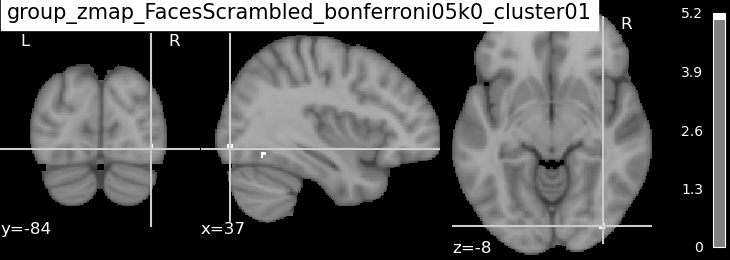

cluster_id  peak_x  peak_y  peak_z  peak_value  volume_mm              aal  \
0           1    37.5   -84.5    -8.5     5.21241         48  Occipital_Inf_R   
1           2    37.5   -60.5   -12.5     5.21298         24       Fusiform_R   

              desikan_killiany  \
0  Right-Cerebral-White-Matter   
1  Right-Cerebral-White-Matter   

                                      harvard_oxford  
0  48.0% Right_Lateral_Occipital_Cortex_inferior_...  
1  23.0% Right_Temporal_Occipital_Fusiform_Cortex...

Scrambled > Faces does not have significant results


In [24]:
import glob
from IPython.display import Image

contrasts = {'FamousUnfamiliar': 'Famous > Unfamiliar',
             'UnfamiliarFamous': 'Unfamiliar > Famous',
             'FacesScrambled': 'Faces > Scrambled',
             'ScrambledFaces': 'Scrambled > Faces'}

for contrast_id, contrast_val in contrasts.items():
    # results folder
    results_dir = os.path.join(ds_path, 'results', 'group-level_bonferroni05k0', 'atlasreader', contrast_id)
    
    # if the directory exists
    if os.path.exists(results_dir):
        print('Results for', contrast_val)
        
        # find the image file        
        cluster1 = glob.glob(os.path.join(results_dir, '*cluster01.png'))        
        # find peak table
        peaks = glob.glob(os.path.join(results_dir, '*_peaks.csv'))
        
        # display the image
        display(Image(cluster1[0]))
        # display the table
        display(pd.read_csv(peaks[0]))
    else:
        print(contrast_val, 'does not have significant results')
            


### Summary for unc. p < .001, k=20

Earlier I have also generated results for *'unc. p < .001, k=20'* and saved it in *group-level_fpr001k20* folder. Let's display these results as well. 

Results for Famous > Unfamiliar


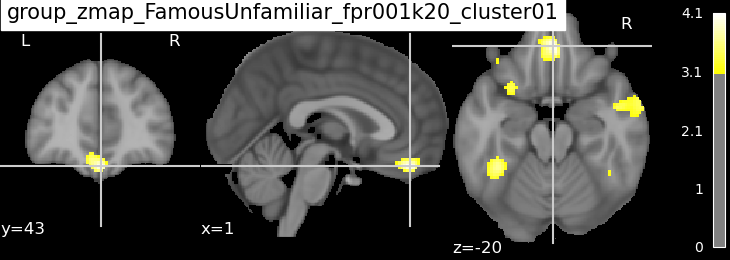

cluster_id  peak_x  peak_y  peak_z  peak_value  volume_mm  \
0           1     1.5    43.5   -20.5     4.11721       2528   
1           2   -38.5   -46.5   -16.5     3.84151       1824   
2           3    63.5     5.5   -22.5     3.55365       1376   
3           4    49.5   -64.5    17.5     3.93860       1096   
4           5    41.5   -50.5   -14.5     3.64761        768   
5           6   -40.5    31.5   -12.5     3.67550        656   
6           7   -28.5    13.5   -18.5     3.61368        576   
7           8    63.5    -6.5    39.5     3.39398        512   
8           9   -46.5   -66.5    25.5     3.50726        384   

                   aal             desikan_killiany  \
0             Rectus_R                      Unknown   
1       Temporal_Inf_L              ctx-lh-fusiform   
2  Temporal_Pole_Mid_R                      Unknown   
3       Temporal_Mid_R      ctx-rh-inferiorparietal   
4       Temporal_Inf_R  Right-Cerebral-White-Matter   
5  Frontal_Inf_Orb_2_L         ctx-lh-parsorbitalis   
6             Insula_L                      Unknown   
7        Postcentral_R                      Unknown   
8            Angular_L      ctx-lh-inferiorparietal   

                                      harvard_oxford  
0                  94.0% Right_Frontal_Medial_Cortex  
1  35.0% Left_Temporal_Occipital_Fusiform_Cortex;...  
2  6.0% Right_Middle_Temporal_Gyrus_anterior_divi...  
3  65.0% Right_Lateral_Occipital_Cortex_superior_...  
4  52.0% Right_Temporal_Occipital_Fusiform_Cortex...  
5  51.0% Left_Frontal_Orbital_Cortex; 6.0% Left_F...  
6  69.0% Left_Frontal_Orbital_Cortex; 14.0% Left_...  
7  7.0% Right_Postcentral_Gyrus; 5.0% Right_Prece...  
8  64.0% Left_Lateral_Occipital_Cortex_superior_d...

Results for Unfamiliar > Famous


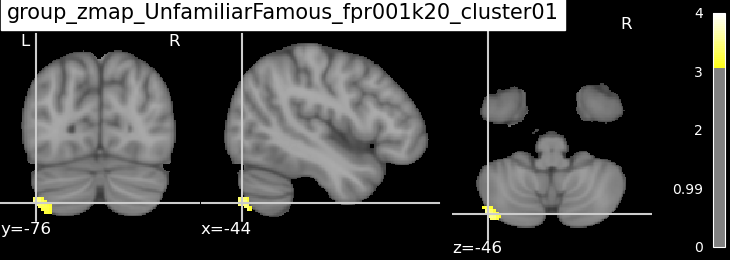

cluster_id  peak_x  peak_y  peak_z  peak_value  volume_mm  \
0           1   -44.5   -76.5   -46.5     3.59421        760   
1           2    47.5    53.5     1.5     3.46095        376   
2           3     7.5    21.5   -10.5     3.97819        224   

                 aal             desikan_killiany  \
0  Cerebelum_Crus2_L                      Unknown   
1    Frontal_Mid_2_R                      Unknown   
2        Olfactory_R  Right-Cerebral-White-Matter   

                  harvard_oxford  
0                    0% no_label  
1       30.0% Right_Frontal_Pole  
2  9.0% Right_Subcallosal_Cortex

Results for Faces > Scrambled


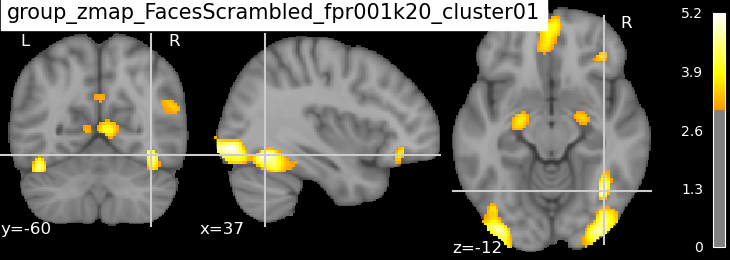

cluster_id  peak_x  peak_y  peak_z  peak_value  volume_mm  \
0            1    37.5   -60.5   -12.5     5.21298      10664   
1            2   -36.5   -88.5   -12.5     4.75340       6456   
2            3     5.5   -60.5     5.5     4.21988       5312   
3            4    -0.5    39.5   -20.5     4.23211       5200   
4            5   -38.5   -10.5   -30.5     4.20340       3080   
5            6    55.5   -64.5    21.5     3.94810       2496   
6            7   -10.5    59.5    25.5     3.88583       1992   
7            8   -48.5   -68.5    19.5     4.31115       1784   
8            9     5.5   -50.5    23.5     4.38300       1688   
9           10    23.5    -6.5   -16.5     3.81412       1336   
10          11    31.5    -4.5   -34.5     3.60883        456   
11          12    -8.5   -62.5     7.5     3.29658        448   
12          13    37.5    35.5   -12.5     3.81101        392   
13          14    21.5   -48.5     5.5     3.70225        360   

                     aal             desikan_killiany  \
0             Fusiform_R  Right-Cerebral-White-Matter   
1        Occipital_Inf_L   Left-Cerebral-White-Matter   
2              Lingual_R               ctx-rh-lingual   
3               Rectus_L                      Unknown   
4         Temporal_Inf_L   Left-Cerebral-White-Matter   
5         Temporal_Mid_R      ctx-rh-inferiorparietal   
6   Frontal_Sup_Medial_L       ctx-lh-superiorfrontal   
7         Temporal_Mid_L      ctx-lh-lateraloccipital   
8            Precuneus_R                      Unknown   
9             Amygdala_R               Right-Amygdala   
10            Fusiform_R            ctx-rh-entorhinal   
11           Calcarine_L                      Unknown   
12   Frontal_Inf_Orb_2_R                      Unknown   
13           Calcarine_R      ctx-rh-isthmuscingulate   

                                       harvard_oxford  
0   23.0% Right_Temporal_Occipital_Fusiform_Cortex...  
1   39.0% Left_Lateral_Occipital_Cortex_inferior_d...  
2   48.0% Right_Lingual_Gyrus; 14.0% Right_Precune...  
3   53.0% Right_Frontal_Medial_Cortex; 39.0% Left_...  
4   38.0% Left_Temporal_Fusiform_Cortex_posterior_...  
5   74.0% Right_Lateral_Occipital_Cortex_superior_...  
6                             54.0% Left_Frontal_Pole  
7   73.0% Left_Lateral_Occipital_Cortex_superior_d...  
8   47.0% Right_Cingulate_Gyrus_posterior_division...  
9                                88.0% Right_Amygdala  
10  31.0% Right_Temporal_Fusiform_Cortex_anterior_...  
11  35.0% Left_Intracalcarine_Cortex; 19.0% Left_P...  
12  47.0% Right_Frontal_Pole; 23.0% Right_Frontal_...  
13  20.0% Right_Precuneous_Cortex; 19.0% Right_Cin...

Results for Scrambled > Faces


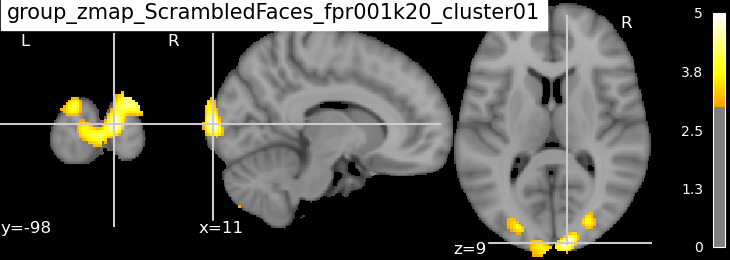

cluster_id  peak_x  peak_y  peak_z  peak_value  volume_mm              aal  \
0           1    11.5   -98.5     9.5     5.03949      16080         Cuneus_R   
1           2   -26.5   -48.5    -8.5     4.56798       3088        Lingual_L   
2           3    31.5   -52.5    -2.5     4.84245       3008         no_label   
3           4    29.5   -72.5   -54.5     3.49298        832    Cerebelum_8_R   
4           5    25.5    39.5    25.5     3.79741        376  Frontal_Mid_2_R   
5           6    47.5   -34.5    41.5     3.42883        328  SupraMarginal_R   
6           7   -26.5    47.5   -10.5     3.36811        184  Frontal_Sup_2_L   

              desikan_killiany  \
0  Right-Cerebral-White-Matter   
1                      Unknown   
2  Right-Cerebral-White-Matter   
3      Right-Cerebellum-Cortex   
4  Right-Cerebral-White-Matter   
5                      Unknown   
6   Left-Cerebral-White-Matter   

                                      harvard_oxford  
0                         69.0% Right_Occipital_Pole  
1  53.0% Left_Lingual_Gyrus; 34.0% Left_Temporal_...  
2                           8.0% Right_Lingual_Gyrus  
3                                        0% no_label  
4  36.0% Right_Frontal_Pole; 12.0% Right_Middle_F...  
5  19.0% Right_Supramarginal_Gyrus_anterior_divis...  
6                            60.0% Left_Frontal_Pole

In [26]:
contrasts = {'FamousUnfamiliar': 'Famous > Unfamiliar',
             'UnfamiliarFamous': 'Unfamiliar > Famous',
             'FacesScrambled': 'Faces > Scrambled',
             'ScrambledFaces': 'Scrambled > Faces'}

for contrast_id, contrast_val in contrasts.items():
    # results folder
    results_dir = os.path.join(ds_path, 'results', 'group-level_fpr001k20', 'atlasreader', contrast_id)
    
    # if the directory exists
    if os.path.exists(results_dir):
        print('Results for', contrast_val)
        
        # find the image file        
        cluster1 = glob.glob(os.path.join(results_dir, '*cluster01.png'))        
        # find peak table
        peaks = glob.glob(os.path.join(results_dir, '*_peaks.csv'))
        
        # display the image
        display(Image(cluster1[0]))
        # display the table
        display(pd.read_csv(peaks[0]))
    else:
        print(contrast_val, 'do not have significant results')